In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
import random
import time
from tqdm import tqdm

import torch_geometric
import networkx as nx
from scipy import sparse as sp

import os
import pickle

import hashlib

from models import GraphRegressionGraphTransformer, GraphTransformerEdges, GraphTransformer

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


In [3]:
from torch_geometric.datasets import ZINC
import torch_geometric.transforms as T

def laplacian_pos_encoding(graph, pos_enc_dim):
    laplacian_edge_index, laplacian_edge_attr = torch_geometric.utils.get_laplacian(graph.edge_index, graph.edge_attr, normalization='rw')
    laplacian_sparse = torch_geometric.utils.to_scipy_sparse_matrix(laplacian_edge_index, laplacian_edge_attr)

    EigVal, EigVec = sp.linalg.eigs(laplacian_sparse, k=pos_enc_dim+1, which='SR', tol=1e-2)
    EigVec = EigVec[:, EigVal.argsort()]
    EigVec = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()

    graph.x = torch.cat([graph.x, EigVec], dim=1)
    return graph

class AddLaplacianPosEncoding(T.BaseTransform):
    def __init__(self, pos_enc_dim=10):
        self.pos_enc_dim = pos_enc_dim
    def __call__(self, graph):
        return laplacian_pos_encoding(graph, self.pos_enc_dim)

In [4]:
pos_enc_dim = 4

data_transforms = T.Compose([
    AddLaplacianPosEncoding(pos_enc_dim),
    T.AddSelfLoops('edge_attr')
    ])


dataset_train = ZINC('data', subset=True, split='train', pre_transform=data_transforms)
dataset_val = ZINC('data', subset=True, split='val', pre_transform=data_transforms)
dataset_test = ZINC('data', subset=True, split='test', pre_transform=data_transforms)

In [5]:
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = torch_geometric.loader.DataLoader(dataset_val, batch_size=32, shuffle=True)
dataloader_test = torch_geometric.loader.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [6]:
n_token_input = torch.unique(dataset_train.x[:,0]).size(0)
n_edges_input = torch.unique(dataset_train.edge_attr).size(0)+1
n_hidden = 64
n_head = 8
n_feedforward = 160
n_layers = 4
batch_size = 32

In [13]:
model = GraphRegressionGraphTransformer(n_token_input, n_hidden, n_head, n_feedforward, n_layers, input_dropout=0.0, dropout=0.0, k=pos_enc_dim, norm='layer')

In [14]:
g = next(iter(dataloader_train))
g = g.to(device)
h = g.x[:,0].to(torch.long)

precomputed_eigenvectors = g.x[:,1:]
sign_flip = torch.rand(precomputed_eigenvectors.size(1)).to(device)
sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
precomputed_eigenvectors = (precomputed_eigenvectors * sign_flip.unsqueeze(0))

y = g.y

In [16]:
model = model.to(device)
out = model(g, h, precomputed_eigenvectors=precomputed_eigenvectors)
nn.L1Loss()(out, y)

tensor(1.6207, device='cuda:0', grad_fn=<MeanBackward0>)

In [10]:
g = next(iter(dataloader_train))
g

DataBatch(x=[760, 5], edge_index=[2, 2400], edge_attr=[2400], y=[32], batch=[760], ptr=[33])

In [14]:
g.edge_index, g.edge_attr = torch_geometric.utils.add_self_loops(g.edge_index, g.edge_attr)

In [22]:
g.edge_index.shape, g.edge_attr.shape

(torch.Size([2, 1640]), torch.Size([1640]))

In [25]:
g2 = T.AddSelfLoops('edge_attr')(g)

In [26]:
g2.edge_index.shape, g2.edge_attr.shape

(torch.Size([2, 2400]), torch.Size([2400]))

In [57]:
embedding = nn.Embedding(n_token_input, n_hidden)

h = g.x[:,0].to(torch.long)
h = embedding(h)
h.shape

torch.Size([769, 64])

In [58]:
embedding_e = nn.Embedding(n_edges_input+1, n_hidden)

e = g.edge_attr
e = embedding_e(e)
e = torch_geometric.utils.to_dense_adj(g.edge_index, batch=g.batch, edge_attr=e)
e.shape

torch.Size([32, 31, 31, 64])

In [59]:
layer = TransformerLayerEdges(n_hidden, n_head, n_feedforward, 0.1, 'layer')

layer(g, h, e)

h torch.Size([769, 64])
e torch.Size([32, 31, 31, 64])
attention_mask_sparse torch.Size([32, 8, 31, 31])
x torch.Size([32, 31, 64])
Q_x torch.Size([32, 8, 31, 8])
E_e torch.Size([32, 8, 31, 31, 8])
intermediate_scores torch.Size([32, 8, 31, 31, 8])
scores torch.Size([32, 8, 31, 31])
e torch.Size([32, 31, 31, 64])
attended_values torch.Size([32, 8, 31, 8])
attended_values torch.Size([32, 31, 64])
x torch.Size([32, 31, 64])
e torch.Size([32, 31, 31, 64])
h torch.Size([769, 64])


(tensor([[ 0.8550, -0.1221,  2.5496,  ..., -1.2301, -0.5582, -0.2343],
         [ 0.9960,  0.3076,  2.5076,  ..., -0.9811, -0.4937, -0.2938],
         [ 1.0642, -0.0920,  2.5787,  ..., -1.1043, -0.6603, -0.2499],
         ...,
         [ 0.2957,  0.1815,  1.3257,  ...,  0.5246,  0.3222, -0.5420],
         [ 0.6350, -1.6593, -2.4357,  ..., -0.0530,  0.6150,  1.1979],
         [ 0.9708, -0.0574,  2.5721,  ..., -1.1647, -0.7113, -0.4355]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[[ 0.0607,  0.0880, -0.1300,  ..., -0.0720,  0.0499, -0.0335],
           [-0.0277,  0.1061, -0.1006,  ...,  0.0369,  0.1199, -0.0844],
           [ 0.0650,  0.0908, -0.1313,  ..., -0.0680,  0.0469, -0.0320],
           ...,
           [ 0.0589,  0.0957, -0.1250,  ..., -0.0873,  0.0526, -0.0395],
           [ 0.0585,  0.0955, -0.1251,  ..., -0.0875,  0.0530, -0.0393],
           [ 0.0583,  0.0956, -0.1251,  ..., -0.0876,  0.0529, -0.0392]],
 
          [[-0.0164,  0.1474, -0.1014,  ..., -0.0834,  0.

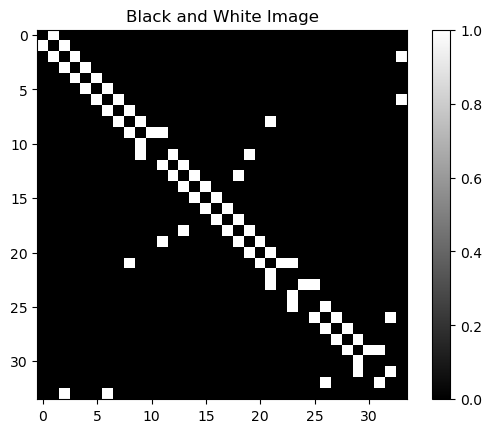

In [33]:
binary_array = attention_mask_sparse[0,0].to(torch.int)

# Plot the binary array as a black-and-white image
plt.imshow(binary_array, cmap='binary_r', interpolation='nearest')
plt.title("Black and White Image")
plt.colorbar()
plt.show()